### What is this notebook?

This notebook is for looking at the dataset and looking for any interesting relationships in the data.

# Package Imports

In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression

In [2]:
mpl.rcParams['figure.dpi'] = 175
plt.rcParams['figure.figsize'] = (6,4)

%load_ext autoreload
%autoreload 2

# Data Summary

In [3]:
organization_names = pd.read_csv('../data/organization_ids.csv')
payment_data = pd.read_csv('../data/payment_ids.csv')

In [4]:
organization_names.head()

,organization_id,organization_created
0,9ba-734503abb584,2016-03-24 19:31:56.545
1,013-1cea58088dd6,2016-03-15 13:14:48.389
2,7df-79d26a057aa3,2016-03-21 11:47:13.375
3,128-c7283516064c,2016-03-20 12:28:11.088
4,881-b39c55213b34,2016-03-07 10:11:53.505


In [5]:
payment_data.head()

,organization_id,timestamp,amount,currency_id,card_payment_entry_mode,device_type,payment_type
0,734-2c29d49a2531,2016-04-12 13:28:29.946,200.00,SEK,EMV,IPAD,Valid
1,f08-9f7318bbb7f4,2016-04-05 20:11:07.584,30.00,GBP,EMV,IPHONE,Valid
2,935-b0673bd6301d,2016-05-05 11:56:38,4.95,GBP,CONTACTLESS_EMV,IPAD,Valid
3,7e0-9171632008bd,2016-06-30 16:23:32,50.00,NOK,EMV,ANDROID,Valid
4,d27-c5e4d935ada8,2016-06-11 14:26:56,25.00,EUR,CONTACTLESS_EMV,IPHONE,Valid


In [6]:
payment_data.shape

(935398, 7)

In [7]:
categorical_columns = [
    'organization_id', 
    'currency_id',
    'card_payment_entry_mode',
    'device_type',
    'payment_type'
]

for col in categorical_columns:
    print("\n\n", col)
    subset = payment_data.loc[:, col].values
    distinct_type_count = len(set(subset))
#     mode_category = stats.mode(subset.values)
    
    print("Distinct number of categories:", distinct_type_count)
    if distinct_type_count < 10:
        print("Categories:", set(subset))



 organization_id
Distinct number of categories: 7264


 currency_id
Distinct number of categories: 5
Categories: {'GBP', 'EUR', 'DKK', 'NOK', 'SEK'}


 card_payment_entry_mode
Distinct number of categories: 6
Categories: {'MANUAL_ENTRY', 'CONTACTLESS_MAGSTRIPE', 'CARD_HOLDER_ENTRY', 'MAGSTRIPE', 'CONTACTLESS_EMV', 'EMV'}


 device_type
Distinct number of categories: 3
Categories: {'IPHONE', 'IPAD', 'ANDROID'}


 payment_type
Distinct number of categories: 2
Categories: {'Valid', 'Invalid'}


# Preliminary Analysis

### First, let's see what % of the orders are valid

In [8]:
total_orders = payment_data.shape[0]
valid_payment_count = payment_data.loc[payment_data.payment_type == 'Valid', :].shape[0]

percent_valid = valid_payment_count / total_orders

print("Percent of orders that were valid payments:", percent_valid)

Percent of orders that were valid payments: 0.933930797371814


### Let's make sure there are no payments prior to the organization creation date

In [9]:
joined_df = organization_names.merge(payment_data, on='organization_id', how='inner')

Are all the vendors in <b>payment_data</b> listed in <b>organization_names</b>?

In [10]:
joined_df.shape[0] == payment_data.shape[0]

True

In [11]:
joined_df.head(10)

,organization_id,organization_created,timestamp,amount,currency_id,card_payment_entry_mode,device_type,payment_type
0,9ba-734503abb584,2016-03-24 19:31:56.545,2016-06-18 11:52:50,850.00,EUR,EMV,ANDROID,Valid
1,9ba-734503abb584,2016-03-24 19:31:56.545,2016-04-20 18:10:15.928,57.50,EUR,EMV,ANDROID,Valid
2,9ba-734503abb584,2016-03-24 19:31:56.545,2016-04-30 15:23:20.46,9.25,EUR,EMV,ANDROID,Valid
3,9ba-734503abb584,2016-03-24 19:31:56.545,2016-05-11 16:10:26,12.29,EUR,EMV,ANDROID,Valid
4,013-1cea58088dd6,2016-03-15 13:14:48.389,2016-04-30 14:18:46.699,39.00,SEK,EMV,ANDROID,Valid
5,013-1cea58088dd6,2016-03-15 13:14:48.389,2016-04-30 10:49:49.607,90.00,SEK,EMV,ANDROID,Valid
6,013-1cea58088dd6,2016-03-15 13:14:48.389,2016-04-30 09:06:35.799,399.00,SEK,EMV,ANDROID,Valid
7,013-1cea58088dd6,2016-03-15 13:14:48.389,2016-04-29 19:25:09.335,10.00,SEK,EMV,ANDROID,Valid
8,013-1cea58088dd6,2016-03-15 13:14:48.389,2016-04-30 11:36:17.10,800.00,SEK,EMV,ANDROID,Valid
9,013-1cea58088dd6,2016-03-15 13:14:48.389,2016-04-30 13:58:07.84,45.00,SEK,EMV,ANDROID,Valid


Let's see how long each timestamp is. Some have fractions of a second, but some don't. 
<br><br>
In the interest of time, we're going to filter everything to the second level so that we can easily transform the data into a <b>datetime.datetime</b> format.

In [12]:
len('2016-06-18 11:52:50')

19

In [13]:
joined_df['organization_created'] = (
    joined_df['organization_created']
    .apply(lambda x: datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S'))
)

joined_df['timestamp'] = (
    joined_df['timestamp']
    .apply(lambda x: datetime.datetime.strptime(x[:19], '%Y-%m-%d %H:%M:%S'))
)

In [14]:
joined_df['timestamp_after_creation'] = [
    1 if row.organization_created <= row.timestamp else 0
    for _, row in joined_df.iterrows()
]

percent_post_creation = np.sum(joined_df['timestamp_after_creation']) / joined_df.shape[0]
print("Percent of purchases coming after organization was created:", percent_post_creation)

Percent of purchases coming after organization was created: 1.0


### Let's visualize a distribution of time from creation date to contact

In [15]:
joined_df['days_from_creation_to_purchase'] = [
    (row['timestamp'] - row['organization_created']).days for _, row in joined_df.iterrows()
]

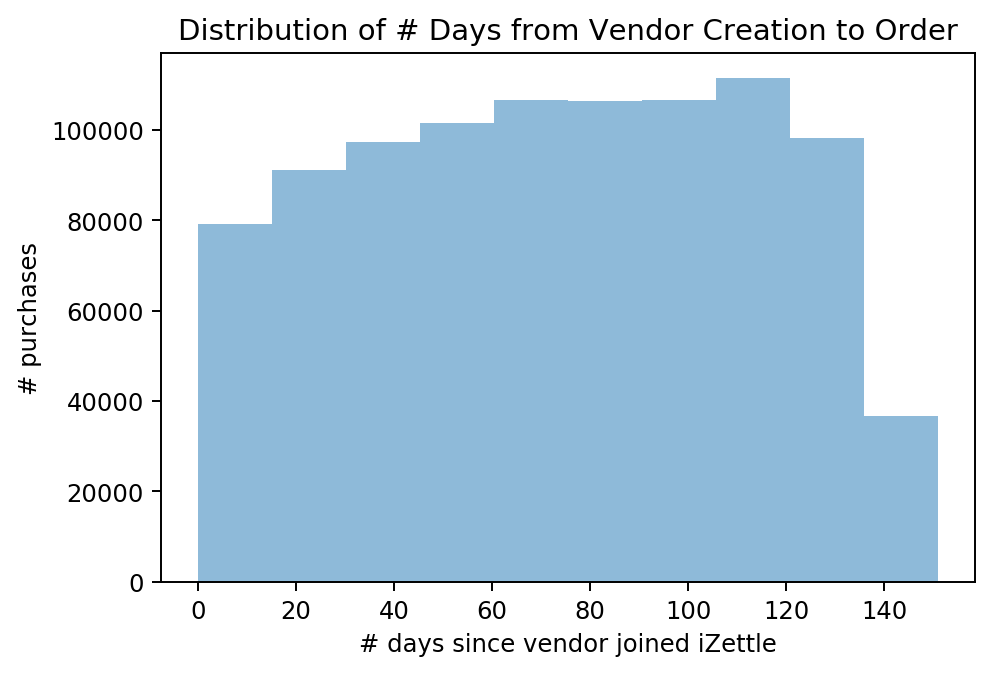

In [16]:
plt.title("Distribution of # Days from Vendor Creation to Order")
plt.hist(joined_df['days_from_creation_to_purchase'], alpha=0.5)
plt.ylabel("# purchases")
plt.xlabel("# days since vendor joined iZettle")
plt.show()

In [17]:
joined_df.loc[joined_df.days_from_creation_to_purchase > 104, :].shape[0] / joined_df.shape[0]

0.27110492004472964

Since we are only looking up to 90 days (3 months) after the customer's first 14 days, we want to filter out any purchases occuring after 104 days, which will remove about 27% of the data.

In [18]:
joined_df = joined_df.loc[joined_df.days_from_creation_to_purchase <= 104, :]

# Format Data for Analysis

Let's format the data so that we have the labels we need for each month.

In [19]:
conversions = {
    'EUR': 1,
    'GBP': 1.14, 
    'DKK': 0.13, 
    'NOK': 0.10,
    'SEK': 0.10
}

joined_df['amount_in_euros'] = [
    row['amount'] * conversions[row['currency_id']] for _, row in joined_df.iterrows()
]

In [20]:
joined_df.drop('amount', inplace=True, axis=1)

In [21]:
which_month = []
for _, row in joined_df.iterrows():
    # month 0 is the training period.
    if row['days_from_creation_to_purchase'] <= 14:
        which_month.append(0)
    elif row['days_from_creation_to_purchase'] <= 44:
        which_month.append(1)
    elif row['days_from_creation_to_purchase'] <= 74:
        which_month.append(2)
    elif row['days_from_creation_to_purchase'] <= 104:
        which_month.append(3)
    else:
        which_month.append(4)

joined_df['which_month'] = which_month
joined_df = joined_df.loc[joined_df['which_month'] < 4, :]

Let's filter to valid purchases, since we're assuming that's all we care about.

In [22]:
valid_df = joined_df.loc[joined_df.payment_type == 'Valid', :]
valid_df.shape

(634207, 11)

Now let's group the data by month and organization.

In [23]:
grouped_df = (
    valid_df
    .loc[:, ['organization_id', 'amount_in_euros', 'which_month']]
    .groupby(['organization_id', 'which_month']).sum()
    .reset_index()
)

In [24]:
grouped_df.head()

,organization_id,which_month,amount_in_euros
0,000-4e6abe9c388d,0,10.000
1,000-f04801b7b25d,1,174.192
2,000-f04801b7b25d,2,24.396
3,000-f04801b7b25d,3,399.456
4,001-0009a4c1c272,2,153.900


We can only train on companies with purchases in the training period, so let's filter to those. <br>
Let's also add in 0's for months with no purchases (after the training period)

In [25]:
filtered_grouped_df = grouped_df.copy(deep=True)

# create values for first row
current_organization = grouped_df.loc[0, 'organization_id']
current_month = -1
skip_org = False

for idx, row in grouped_df.iterrows():
    
    if row.organization_id == current_organization:
        
        if skip_org:
            continue
            
        if row.which_month == current_month + 1:
            pass
        
        # Case when there was a month (or two) with no purchases
        else:
            for month in range(current_month + 1, row.which_month + 1):
                new_row = pd.DataFrame(
                    data={
                        'organization_id': [row.organization_id], 
                        'which_month': [month], 
                        'amount_in_euros': [0]
                    }
                )
                filtered_grouped_df = filtered_grouped_df.append(new_row)
            
        current_month += 1
        
    # case when we're switching new a new organization id
    else:
        
        # Fill in the remainder of missing months with 0's
        if current_month < 3 and not skip_org:
            
            for month in range(current_month + 1, 4):
                new_row = pd.DataFrame(
                    data={
                        'organization_id': [current_organization], 
                        'which_month': [month], 
                        'amount_in_euros': [0]
                    }
                )
                filtered_grouped_df = filtered_grouped_df.append(new_row)
                
        # Reset all the variables
        current_organization = row.organization_id
        current_month = 0
        skip_org = False
        
        # Filter out companies with no training data
        if row.which_month != 0:
            
            filtered_grouped_df = (
                filtered_grouped_df
                .loc[filtered_grouped_df['organization_id'] != current_organization, :]
            )
            skip_org = True
            
        else:
            pass
    
    # Finally, let's handle the last row. We're just going to remove it for simplicity.
    if idx == grouped_df.index[-1]:
        filtered_grouped_df = (
            filtered_grouped_df
            .loc[filtered_grouped_df['organization_id'] != current_organization, :]
        )

Let's make sure that worked!

In [26]:
filtered_grouped_df = (
    filtered_grouped_df
    .groupby(['organization_id', 'which_month'])
    .sum()
)

In [27]:
filtered_grouped_df.head(9)

amount_in_euros
organization_id  which_month                 
000-4e6abe9c388d 0                     10.000
                 1                      0.000
                 2                      0.000
                 3                      0.000
001-3b5eba101430 0                     60.648
                 1                    114.000
                 2                      0.000
                 3                      0.000
001-3d39160884ba 0                      2.280

In [28]:
filtered_grouped_df.tail()

amount_in_euros
organization_id  which_month                 
ffe-f72cc7a435de 3                        0.0
fff-7d91a0b3022b 0                        1.0
                 1                        0.0
                 2                        0.0
                 3                        0.0

# Feature Analysis

This section looks at what will have predictive power for CPV.

### Let's start with the easiest: does CPV during the first 14 days affect the CPV for months 1-3?

In [29]:
organizations = set([val[0] for val in filtered_grouped_df.index])

training_cpv = []
month_1_cpv = []
month_2_cpv = []
month_3_cpv = []

for org in organizations:
    training_cpv.append(filtered_grouped_df.loc[(org, 0), 'amount_in_euros'])
    month_1_cpv.append(filtered_grouped_df.loc[(org, 1), 'amount_in_euros'])
    month_2_cpv.append(filtered_grouped_df.loc[(org, 2), 'amount_in_euros'])
    month_3_cpv.append(filtered_grouped_df.loc[(org, 3), 'amount_in_euros'])
    
training_cpv = np.array(training_cpv)
month_1_cpv = np.array(month_1_cpv)
month_2_cpv = np.array(month_2_cpv)
month_3_cpv = np.array(month_3_cpv)

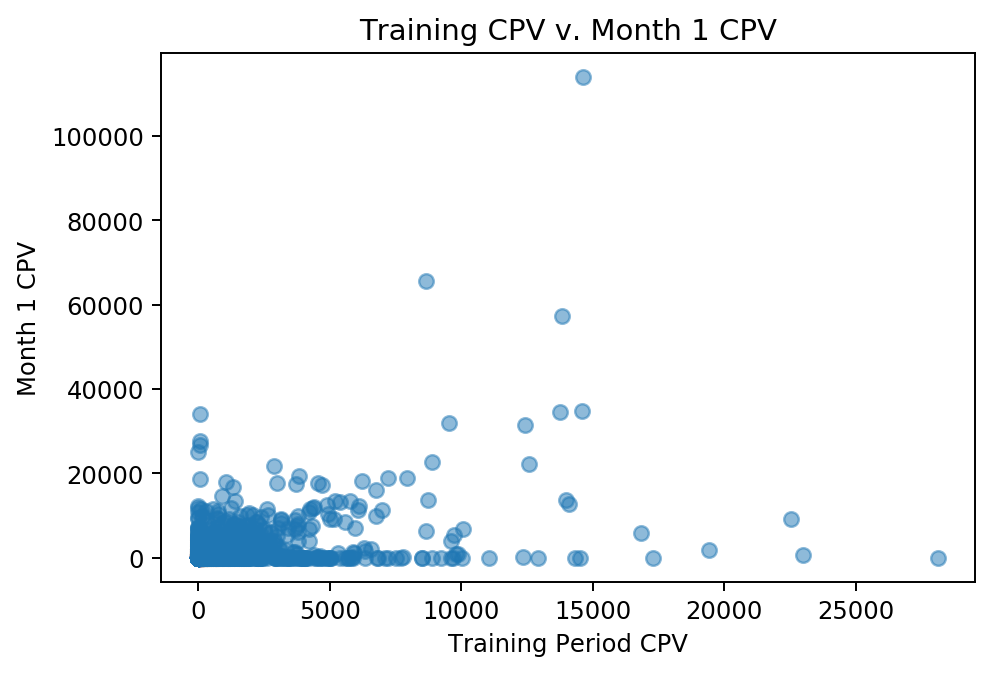

In [30]:
plt.scatter(training_cpv, month_1_cpv, alpha=0.5)
plt.title("Training CPV v. Month 1 CPV")
plt.xlabel("Training Period CPV")
plt.ylabel("Month 1 CPV")
plt.show()

Clearly, we need to do some outlier removal.

In [31]:
filter_max = np.percentile(training_cpv, 95)
filter_min = np.percentile(training_cpv, 5)

filter_indices = [
    idx for idx in range(training_cpv.shape[0]) 
    if training_cpv[idx] < filter_max and training_cpv[idx] > filter_min
]

training_cpv = training_cpv[filter_indices]
month_1_cpv = month_1_cpv[filter_indices]
month_2_cpv = month_2_cpv[filter_indices]
month_3_cpv = month_3_cpv[filter_indices]

Alright, let's try that again with outliers filtered out.

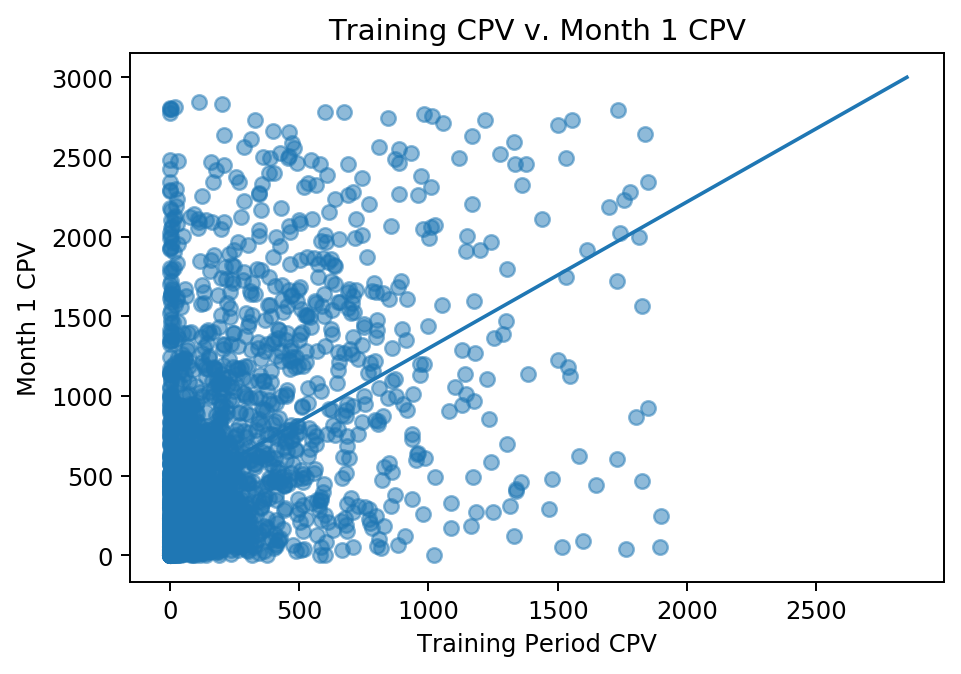

R-squared value: 0.19872872483031545


In [32]:
month_1_filter_min = np.percentile(month_1_cpv, 5)
month_1_filter_max = np.percentile(month_1_cpv, 95)

month_1_filter_indices = [
    idx for idx in range(training_cpv.shape[0]) 
    if month_1_cpv[idx] > month_1_filter_min and month_1_cpv[idx] < month_1_filter_max
]

month_1_filtered = month_1_cpv[month_1_filter_indices]
training_filtered = training_cpv[month_1_filter_indices]

lr = LinearRegression()
lr.fit(training_filtered.reshape(-1,1), month_1_filtered)
plt.plot(
    range(0, int(month_1_filter_max)), 
    lr.predict(
        np.array(range(0, int(month_1_filter_max))).reshape(-1,1)
    )
)

plt.scatter(training_filtered, month_1_filtered, alpha=0.5)
plt.title("Training CPV v. Month 1 CPV")
plt.xlabel("Training Period CPV")
plt.ylabel("Month 1 CPV")
plt.show()

print("R-squared value:", lr.score(training_filtered.reshape(-1,1), month_1_filtered))

<br><br>
Given more time, I would love to experiment with what depth of outlier removal maximizes the R^2, but let's move on to the relationship with month 2 cpv.<br>

We expect, intuitively, that it will be harder to predict for month 2, and thus we will have a lower coefficient of determination.

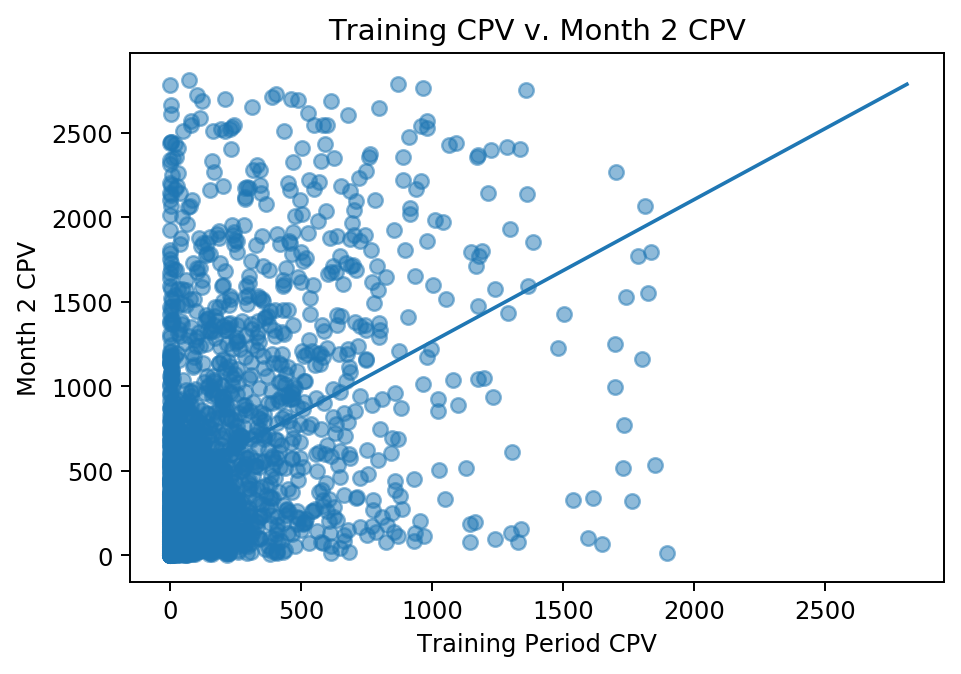

R-squared value: 0.1471684455690141


In [33]:
month_2_filter_min = np.percentile(month_2_cpv, 5)
month_2_filter_max = np.percentile(month_2_cpv, 95)

month_2_filter_indices = [
    idx for idx in range(training_cpv.shape[0]) 
    if month_2_cpv[idx] > month_2_filter_min and month_2_cpv[idx] < month_2_filter_max
]

month_2_filtered = month_2_cpv[month_2_filter_indices]
training_filtered = training_cpv[month_2_filter_indices]

lr = LinearRegression()
lr.fit(training_filtered.reshape(-1,1), month_2_filtered)
plt.plot(
    range(0, int(month_2_filter_max)), 
    lr.predict(
        np.array(range(0, int(month_2_filter_max))).reshape(-1,1)
    )
)

plt.scatter(training_filtered, month_2_filtered, alpha=0.5)
plt.title("Training CPV v. Month 2 CPV")
plt.xlabel("Training Period CPV")
plt.ylabel("Month 2 CPV")
plt.show()

print("R-squared value:", lr.score(training_filtered.reshape(-1,1), month_2_filtered))

<br><br>
Our hypothesis about the R^2 value getting lower is confirmed. Let's take a look at month 3. We will probably see event more of a decrease in R^2 here.

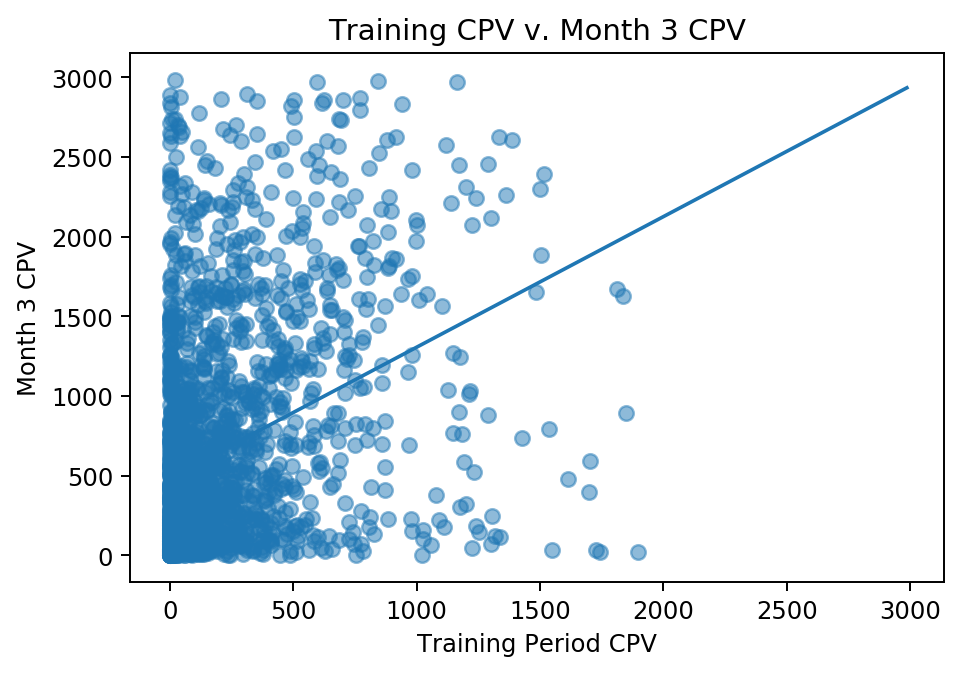

R-squared value: 0.11752778163606414


In [34]:
month_3_filter_min = np.percentile(month_3_cpv, 5)
month_3_filter_max = np.percentile(month_3_cpv, 95)

month_3_filter_indices = [
    idx for idx in range(training_cpv.shape[0]) 
    if month_3_cpv[idx] > month_3_filter_min and month_3_cpv[idx] < month_3_filter_max
]

month_3_filtered = month_3_cpv[month_3_filter_indices]
training_filtered = training_cpv[month_3_filter_indices]

lr = LinearRegression()
lr.fit(training_filtered.reshape(-1,1), month_3_filtered)
plt.plot(
    range(0, int(month_3_filter_max)), 
    lr.predict(
        np.array(range(0, int(month_3_filter_max))).reshape(-1,1)
    )
)

plt.scatter(training_filtered, month_3_filtered, alpha=0.5)
plt.title("Training CPV v. Month 3 CPV")
plt.xlabel("Training Period CPV")
plt.ylabel("Month 3 CPV")
plt.show()

print("R-squared value:", lr.score(training_filtered.reshape(-1,1), month_3_filtered))

<br><br>
Since there is a clear positive correlation between the training period CPV and the Months 1-3 CPV, we can use that as an input feature.

### Does the mode currency affect the Card Payment Volume?

In [35]:
training_dataset = joined_df.loc[joined_df['which_month'] == 0, :].copy()
training_dataset['currency_counts'] = np.ones(training_dataset.shape[0])

currency_counts = (
    training_dataset
    .loc[:, ['organization_id', 'currency_id', 'currency_counts', 'amount_in_euros']]
    .groupby(['organization_id', 'currency_id']).sum()
    .reset_index()
)

In [36]:
currency_counts.head()

,organization_id,currency_id,currency_counts,amount_in_euros
0,000-4e6abe9c388d,EUR,1.0,10.000
1,001-3b5eba101430,GBP,1.0,60.648
2,001-3d39160884ba,GBP,2.0,2.280
3,001-3e822db41946,EUR,26.0,892.700
4,001-7162bc3e0996,NOK,3.0,744.000


In [37]:
transaction_counts = {}
mode_currencies = {}

for _, row in currency_counts.iterrows():
    
    # for new organization_ids
    if transaction_counts.get(row.organization_id, -1) < 1:
        transaction_counts[row.organization_id] = row.currency_counts
        mode_currencies[row.organization_id] = row.currency_id
    
    # for existing organization_ids where we have more transactions in a different currency
    elif row.currency_counts > transaction_counts[row.organization_id]:
        transaction_counts[row.organization_id] = row.currency_counts
        mode_currencies[row.organization_id] = row.currency_id

In [38]:
mode_currency_list = [
    mode_currencies.get(row.organization_id, 'UNK') for _, row in training_dataset.iterrows()
]
training_dataset['mode_currency'] = mode_currency_list

In [39]:
training_dataset.head()

,organization_id,organization_created,timestamp,currency_id,card_payment_entry_mode,device_type,payment_type,timestamp_after_creation,days_from_creation_to_purchase,amount_in_euros,which_month,currency_counts,mode_currency
51,128-c7283516064c,2016-03-20 12:28:11,2016-03-31 08:02:43,EUR,EMV,IPHONE,Valid,1,10,50.0,0,1.0,EUR
60,128-c7283516064c,2016-03-20 12:28:11,2016-03-31 10:07:30,EUR,EMV,IPHONE,Valid,1,10,25.0,0,1.0,EUR
72,128-c7283516064c,2016-03-20 12:28:11,2016-03-24 12:55:36,EUR,EMV,IPHONE,Valid,1,4,25.0,0,1.0,EUR
81,128-c7283516064c,2016-03-20 12:28:11,2016-03-22 12:21:20,EUR,EMV,IPHONE,Valid,1,1,1.0,0,1.0,EUR
84,128-c7283516064c,2016-03-20 12:28:11,2016-03-26 09:57:54,EUR,EMV,IPHONE,Valid,1,5,25.0,0,1.0,EUR


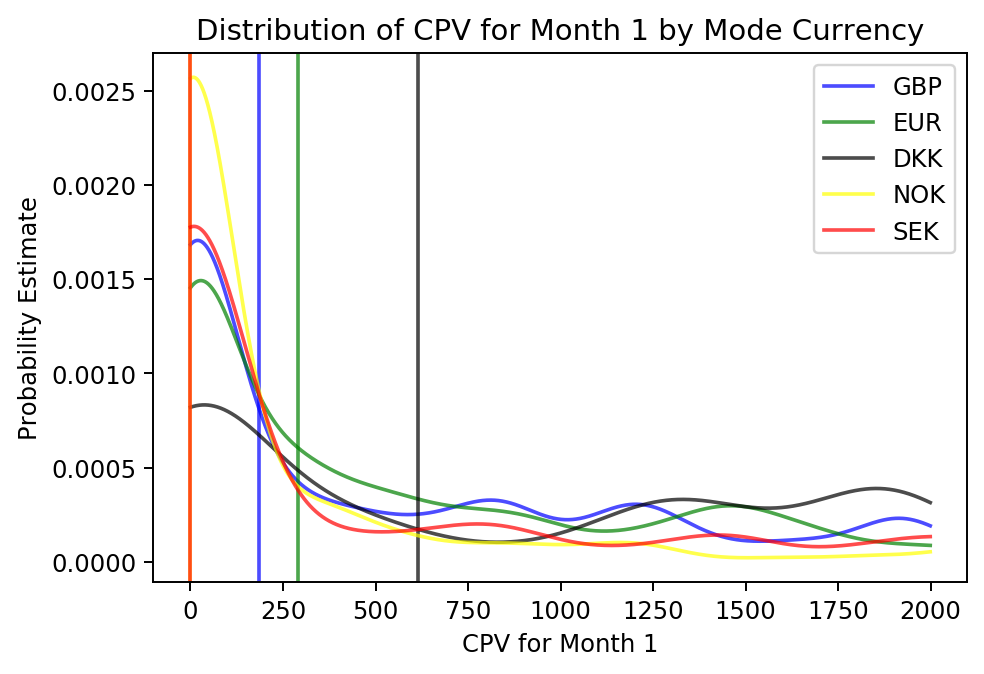

In [40]:
currency_df = filtered_grouped_df.reset_index().merge(
    training_dataset.loc[:, ['organization_id', 'mode_currency']],
    on='organization_id',
    how='inner'
)

colors = ['blue', 'green', 'black', 'yellow', 'red']
currencies = list(set(mode_currency_list))
# We're going to look at the CPV for month 1 to simplify the analysis
for currency, color in zip(currencies, colors):
    subset_cpv = currency_df.loc[
        (
            currency_df['mode_currency'] == currency
        ) & (
            currency_df['which_month'] == 1
        ) & (
            currency_df['amount_in_euros'] < month_1_filter_max
        ), 
        'amount_in_euros'
    ].values
    kernel = gaussian_kde(subset_cpv)
    
    plt.plot(range(0,2000), kernel(range(0,2000)), c=color, label=currency, alpha=0.7)
    plt.axvline(np.median(subset_cpv), color=color, alpha=0.7)
    
plt.title("Distribution of CPV for Month 1 by Mode Currency")
plt.xlabel("CPV for Month 1")
plt.ylabel("Probability Estimate")
plt.legend()
plt.show()

We see fairly large differences in the medians/distributions here, so we can try this out as an input feature.

### Does device_type affect the card payment volume

We will use the same EDA technique we used to look  at the currency.

In [41]:
device_types = ['ANDROID', 'IPAD', 'IPHONE']

training_dataset = joined_df.loc[joined_df['which_month'] == 0, :].copy()
training_dataset['device_counts'] = np.ones(training_dataset.shape[0])

device_counts = (
    training_dataset
    .loc[:, ['organization_id', 'device_type', 'device_counts']]
    .groupby(['organization_id', 'device_type']).sum()
    .reset_index()
)

transaction_counts = {}
mode_devices = {}

for _, row in device_counts.iterrows():
    
    # for new organization_ids
    if transaction_counts.get(row.organization_id, -1) < 1:
        transaction_counts[row.organization_id] = row.device_counts
        mode_devices[row.organization_id] = row.device_type
    
    # for existing organization_ids where we have more transactions ion a different device
    elif row.device_counts > transaction_counts[row.organization_id]:
        transaction_counts[row.organization_id] = row.device_counts
        mode_currencies[row.organization_id] = row.device_type
        
mode_device_list = [
    mode_devices.get(row.organization_id, 'UNK') for _, row in training_dataset.iterrows()
]
training_dataset['mode_device'] = mode_device_list

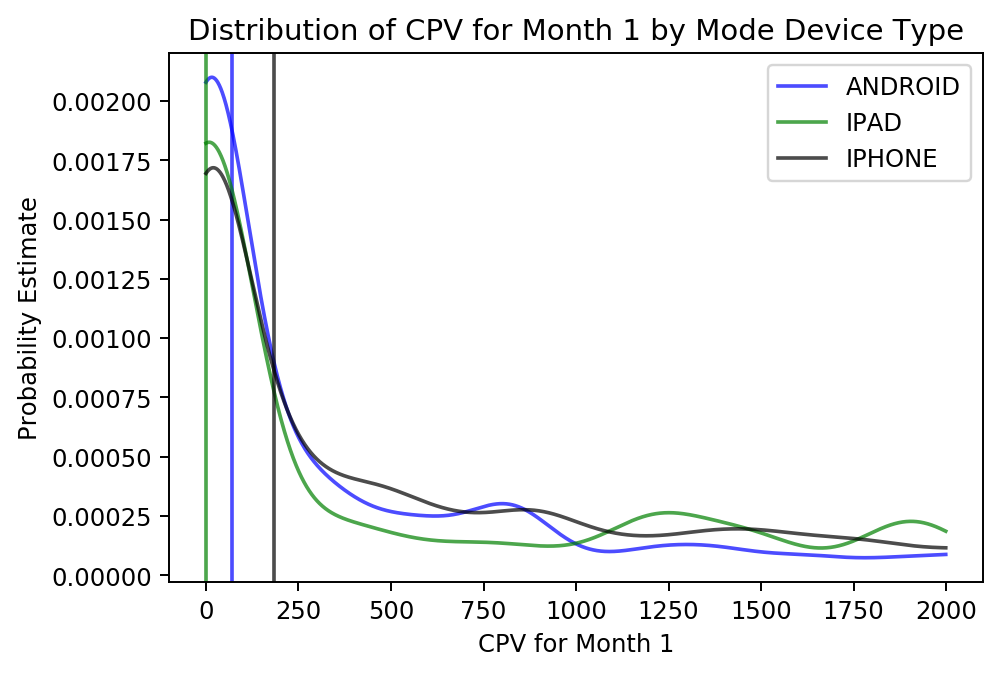

In [42]:
device_df = filtered_grouped_df.reset_index().merge(
    training_dataset.loc[:, ['organization_id', 'mode_device']],
    on='organization_id',
    how='inner'
)

colors = ['blue', 'green', 'black']

# We're going to look at the CPV for month 1 to simplify the analysis
for device, color in zip(device_types, colors):
    subset_cpv = device_df.loc[
        (
            device_df['mode_device'] == device
        ) & (
            device_df['which_month'] == 1
        ) & (
            device_df['amount_in_euros'] < month_1_filter_max
        ), 
        'amount_in_euros'
    ].values
    kernel = gaussian_kde(subset_cpv)
    
    plt.plot(range(0,2000), kernel(range(0,2000)), c=color, label=device, alpha=0.7)
    plt.axvline(np.median(subset_cpv), color=color, alpha=0.7)
    
plt.title("Distribution of CPV for Month 1 by Mode Device Type")
plt.xlabel("CPV for Month 1")
plt.ylabel("Probability Estimate")
plt.legend()
plt.show()

There is also a sizeable distance between the medians across different devices, so we will use this as an input feature as well.

### Does the number of payments in the training period determine the CPV in the test period?

In [43]:
count_grouped_df = (
    valid_df
    .loc[:, ['organization_id', 'amount_in_euros', 'which_month']]
    .groupby(['organization_id', 'which_month']).count()
    .reset_index()
)
count_grouped_df.columns = ['organization_id', 'which_month', 'transaction_count']
count_grouped_df.head()

,organization_id,which_month,transaction_count
0,000-4e6abe9c388d,0,1
1,000-f04801b7b25d,1,8
2,000-f04801b7b25d,2,2
3,000-f04801b7b25d,3,15
4,001-0009a4c1c272,2,3


In [44]:
filtered_count_df = count_grouped_df.copy(deep=True)

# create values for first row
current_organization = count_grouped_df.loc[0, 'organization_id']
current_month = -1
skip_org = False

for idx, row in count_grouped_df.iterrows():
    
    if row.organization_id == current_organization:
        
        if skip_org:
            continue
            
        if row.which_month == current_month + 1:
            pass
        
        # Case when there was a month (or two) with no purchases
        else:
            for month in range(current_month + 1, row.which_month + 1):
                new_row = pd.DataFrame(
                    data={
                        'organization_id': [row.organization_id], 
                        'which_month': [month], 
                        'transaction_count': [0]
                    }
                )
                filtered_count_df = filtered_count_df.append(new_row)
            
        current_month += 1
        
    # case when we're switching new a new organization id
    else:
        
        # Fill in the remainder of missing months with 0's
        if current_month < 3 and not skip_org:
            
            for month in range(current_month + 1, 4):
                new_row = pd.DataFrame(
                    data={
                        'organization_id': [current_organization], 
                        'which_month': [month], 
                        'transaction_count': [0]
                    }
                )
                filtered_count_df = filtered_count_df.append(new_row)
                
        # Reset all the variables
        current_organization = row.organization_id
        current_month = 0
        skip_org = False
        
        # Filter out companies with no training data
        if row.which_month != 0:
            
            filtered_count_df = (
                filtered_count_df
                .loc[filtered_count_df['organization_id'] != current_organization, :]
            )
            skip_org = True
            
        else:
            pass
    
    # Finally, let's handle the last row. We're just going to remove it for simplicity.
    if idx == count_grouped_df.index[-1]:
        filtered_count_df = (
            filtered_count_df
            .loc[filtered_count_df['organization_id'] != current_organization, :]
        )

filtered_count_df = (
    filtered_count_df
    .groupby(['organization_id', 'which_month'])
    .sum()
)

In [45]:
filtered_count_df.head(9)

transaction_count
organization_id  which_month                   
000-4e6abe9c388d 0                            1
                 1                            0
                 2                            0
                 3                            0
001-3b5eba101430 0                            1
                 1                            1
                 2                            0
                 3                            0
001-3d39160884ba 0                            2

In [46]:
filtered_count_df.tail()

transaction_count
organization_id  which_month                   
ffe-f72cc7a435de 3                            0
fff-7d91a0b3022b 0                            1
                 1                            0
                 2                            0
                 3                            0

In [47]:
organizations_count = set([val[0] for val in filtered_count_df.index])

training_count = []
month_1_cpv = []
month_2_cpv = []
month_3_cpv = []

for org in organizations_count:
    training_count.append(filtered_count_df.loc[(org, 0), 'transaction_count'])
    month_1_cpv.append(filtered_grouped_df.loc[(org, 1), 'amount_in_euros'])
    month_2_cpv.append(filtered_grouped_df.loc[(org, 2), 'amount_in_euros'])
    month_3_cpv.append(filtered_grouped_df.loc[(org, 3), 'amount_in_euros'])
    
training_count = np.array(training_count)
month_1_cpv = np.array(month_1_cpv)
month_2_cpv = np.array(month_2_cpv)
month_3_cpv = np.array(month_3_cpv)

filter_max = np.percentile(training_count, 90)
filter_min = np.percentile(training_count, 5)

filter_indices = [
    idx for idx in range(training_count.shape[0]) 
    if training_count[idx] < filter_max and training_count[idx] > filter_min
]

training_count = training_count[filter_indices]
month_1_cpv = month_1_cpv[filter_indices]
month_2_cpv = month_2_cpv[filter_indices]
month_3_cpv = month_3_cpv[filter_indices]

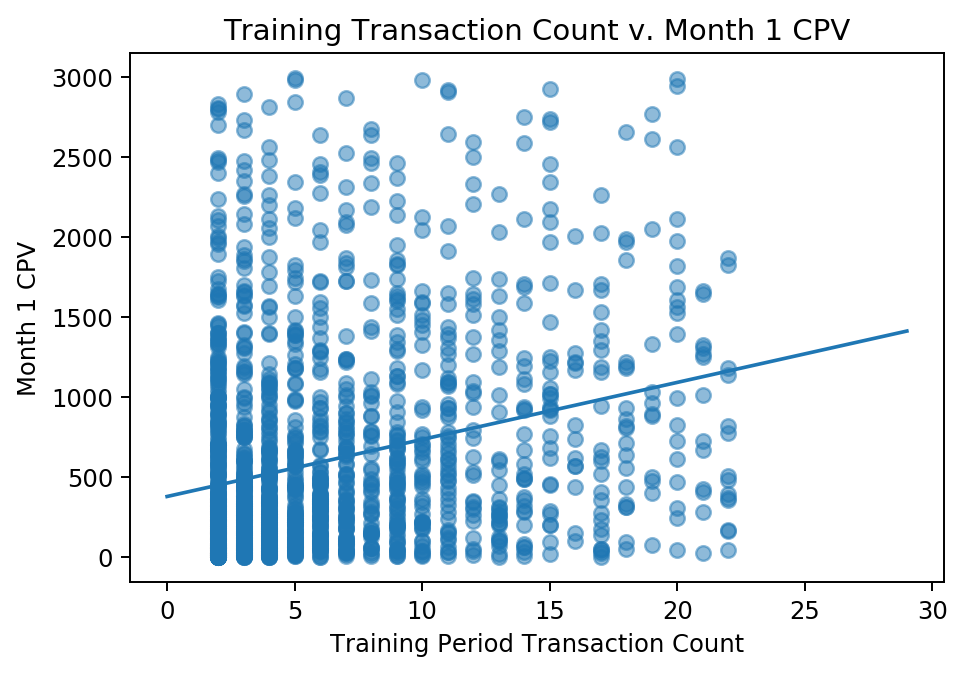

R-squared value: 0.0705232224508987


In [48]:
month_1_filter_min = np.percentile(month_1_cpv, 5)
month_1_filter_max = np.percentile(month_1_cpv, 95)

month_1_filter_indices = [
    idx for idx in range(training_count.shape[0]) 
    if month_1_cpv[idx] > month_1_filter_min and month_1_cpv[idx] < month_1_filter_max
]

month_1_filtered = month_1_cpv[month_1_filter_indices]
training_filtered = training_count[month_1_filter_indices]

lr = LinearRegression()
lr.fit(training_filtered.reshape(-1,1), month_1_filtered)
plt.plot(
    range(0, 30), 
    lr.predict(
        np.array(range(0, 30)).reshape(-1,1)
    )
)

plt.scatter(training_filtered, month_1_filtered, alpha=0.5)
plt.title("Training Transaction Count v. Month 1 CPV")
plt.xlabel("Training Period Transaction Count")
plt.ylabel("Month 1 CPV")
plt.show()

print("R-squared value:", lr.score(training_filtered.reshape(-1,1), month_1_filtered))

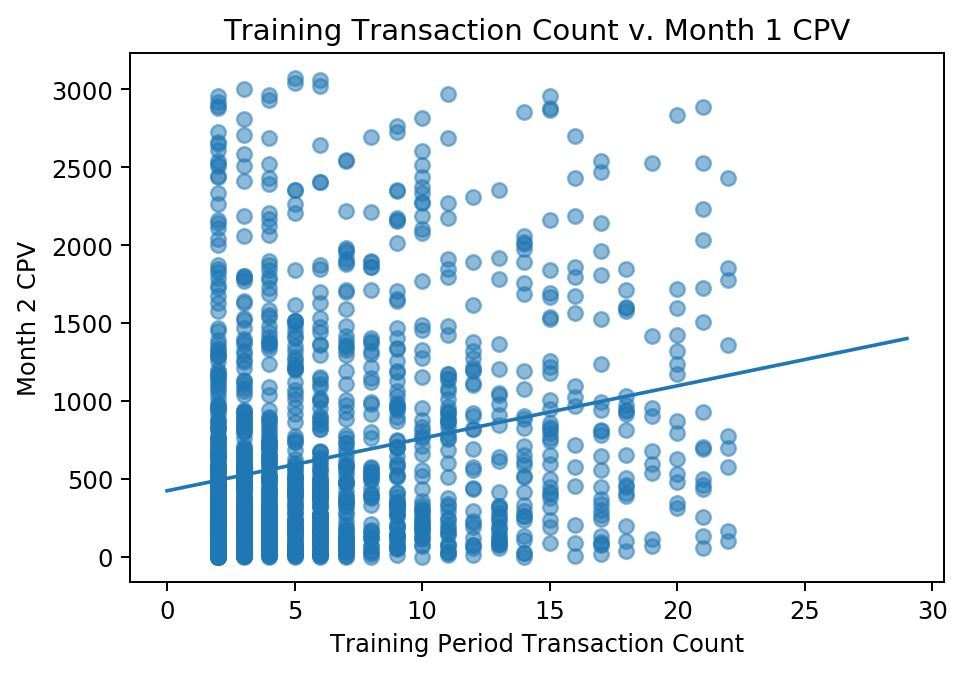

R-squared value: 0.05734330787820707


In [49]:
month_2_filter_min = np.percentile(month_2_cpv, 5)
month_2_filter_max = np.percentile(month_2_cpv, 95)

month_2_filter_indices = [
    idx for idx in range(training_count.shape[0]) 
    if month_2_cpv[idx] > month_2_filter_min and month_2_cpv[idx] < month_2_filter_max
]

month_2_filtered = month_2_cpv[month_2_filter_indices]
training_filtered = training_count[month_2_filter_indices]

lr = LinearRegression()
lr.fit(training_filtered.reshape(-1,1), month_2_filtered)
plt.plot(
    range(0, 30), 
    lr.predict(
        np.array(range(0, 30)).reshape(-1,1)
    )
)

plt.scatter(training_filtered, month_2_filtered, alpha=0.5)
plt.title("Training Transaction Count v. Month 1 CPV")
plt.xlabel("Training Period Transaction Count")
plt.ylabel("Month 2 CPV")
plt.show()

print("R-squared value:", lr.score(training_filtered.reshape(-1,1), month_2_filtered))

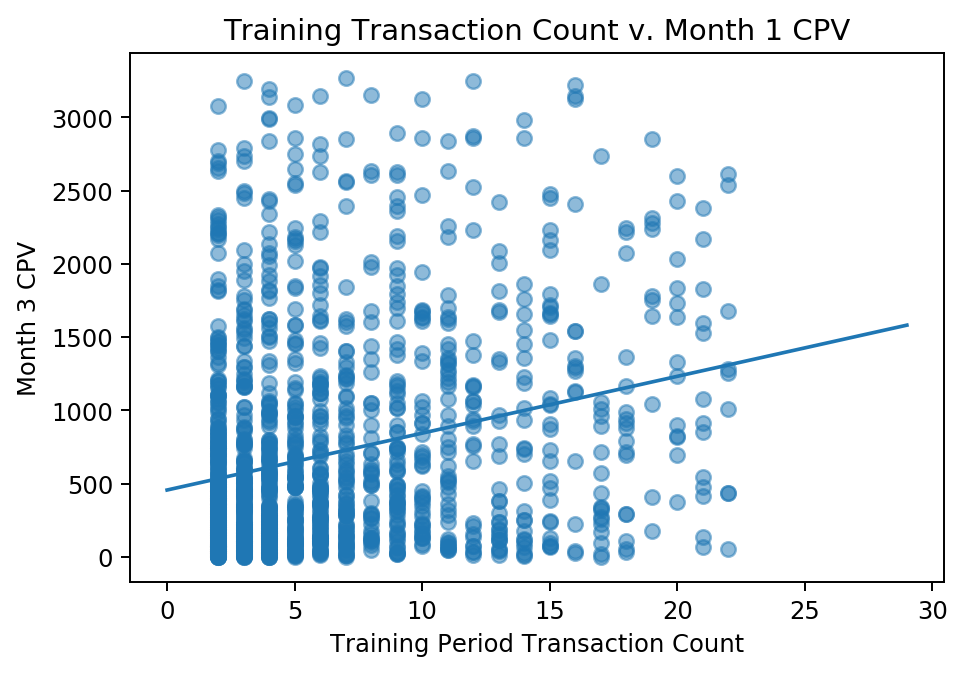

R-squared value: 0.0652687045570366


In [50]:
month_3_filter_min = np.percentile(month_3_cpv, 5)
month_3_filter_max = np.percentile(month_3_cpv, 95)

month_3_filter_indices = [
    idx for idx in range(training_count.shape[0]) 
    if month_3_cpv[idx] > month_3_filter_min and month_3_cpv[idx] < month_3_filter_max
]

month_3_filtered = month_3_cpv[month_3_filter_indices]
training_filtered = training_count[month_3_filter_indices]

lr = LinearRegression()
lr.fit(training_filtered.reshape(-1,1), month_3_filtered)
plt.plot(
    range(0, 30), 
    lr.predict(
        np.array(range(0, 30)).reshape(-1,1)
    )
)

plt.scatter(training_filtered, month_3_filtered, alpha=0.5)
plt.title("Training Transaction Count v. Month 1 CPV")
plt.xlabel("Training Period Transaction Count")
plt.ylabel("Month 3 CPV")
plt.show()

print("R-squared value:", lr.score(training_filtered.reshape(-1,1), month_3_filtered))

It looks like there is a small correlation between the number of training period transactions and the CPV in the following months, so we will include this feature as well.

# Features I would explore with more time
<ul>
    <li> Does Card Payment Entry Mode affect the card payment volume? </li>
    <li> Does month of year that the organization was created affect the card payment volume? </li>
    <li> Does the ratio of invalid payments affect the card payment volume? </li>
    <li> Experiment with standard deviation of the number of payments per day as an input feature </li>
    <li> Does average order value affect the card payment volume? </li>
</ul>